<a href="https://colab.research.google.com/github/BhurkeSiddhesh/ai-platform-text-classifier-shap/blob/master/ai_stackoverflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# You need TF 1.13.1 to deploy this on AI Platform 
!pip install tensorflow==1.13.1

import tensorflow as tf 
import pandas as pd
import numpy as np 

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

## Downloading and preprocessing data

In [0]:
# Authenticate to your cloud account
from google.colab import auth
auth.authenticate_user()

In [3]:
# Download the Stack Overflow data (or replace with your own text data)
!gsutil cp 'gs://cloudml-demo-lcm/SO_ml_tags_avocado_188k_v2.csv' ./

Copying gs://cloudml-demo-lcm/SO_ml_tags_avocado_188k_v2.csv...
- [1 files][276.7 MiB/276.7 MiB]                                                
Operation completed over 1 objects/276.7 MiB.                                    


In [30]:
data = pd.read_csv('SO_ml_tags_avocado_188k_v2.csv', names=['tags', 'original_tags', 'text'], header=0)
data = data.drop(columns=['original_tags'])
data = data.dropna()

data = shuffle(data, random_state=22)
data.head()

,tags,text
182914,"tensorflow,keras",avocado image captioning model not compiling b...
48361,pandas,return excel file from avocado with flask in f...
181447,"tensorflow,keras",validating with generator (avocado) i'm trying...
66307,pandas,avocado multiindex dataframe selecting data gi...
11283,pandas,get rightmost non-zero value position for each...


In [5]:
# Encode top tags to multi-hot
tags_split = [tags.split(',') for tags in data['tags'].values]
print(tags_split)

[['tensorflow', 'keras'], ['pandas'], ['tensorflow', 'keras'], ['pandas'], ['pandas'], ['pandas'], ['pandas'], ['tensorflow'], ['pandas'], ['matplotlib'], ['matplotlib'], ['tensorflow'], ['matplotlib'], ['scikitlearn'], ['scikitlearn'], ['scikitlearn'], ['pandas'], ['keras'], ['pandas'], ['matplotlib'], ['scikitlearn'], ['pandas'], ['pandas'], ['pandas'], ['keras'], ['pandas'], ['pandas'], ['pandas'], ['tensorflow'], ['tensorflow'], ['pandas'], ['tensorflow'], ['pandas'], ['pandas'], ['pandas'], ['tensorflow'], ['matplotlib'], ['matplotlib'], ['matplotlib'], ['pandas'], ['tensorflow'], ['keras'], ['pandas'], ['matplotlib'], ['pandas'], ['scikitlearn'], ['pandas'], ['pandas'], ['matplotlib', 'scikitlearn'], ['tensorflow', 'keras'], ['pandas', 'scikitlearn'], ['pandas'], ['tensorflow'], ['pandas', 'scikitlearn'], ['scikitlearn'], ['pandas'], ['pandas'], ['pandas'], ['pandas'], ['tensorflow'], ['tensorflow'], ['pandas'], ['scikitlearn'], ['scikitlearn'], ['tensorflow'], ['pandas'], ['tens

In [6]:
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)
num_tags = len(tags_encoded[0])
print(data['text'].values[0])
print(tag_encoder.classes_)
print(tags_encoded[0])

avocado image captioning model not compiling because of concatenate layer when mask_zero=true in a previous layer i am new to avocado and i am trying to implement a model for an image captioning project.   i am trying to reproduce the model from image captioning pre-inject architecture (the picture is taken from this paper: where to put the image in an image captioning generator) (but with a minor difference: generating a word at each time step instead of only generating a single word at the end), in which the inputs for the lstm at the first time step are the embedded cnn features. the lstm should support variable input length and in order to do this i padded all the sequences with zeros so that all of them have maxlen time steps.  the code for the model i have right now is the following:    def get_model(model_name, batch_size, maxlen, voc_size, embed_size,          cnn_feats_size, dropout_rate):      # create input layer for the cnn features     cnn_feats_input = input(shape=(cnn_fe

In [7]:
# Split our data into train and test sets
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 150559
Test size: 37640


In [0]:
# Split our labels into train and test sets
train_tags = tags_encoded[:train_size]
test_tags = tags_encoded[train_size:]

In [9]:
# Pre-processing data: create our tokenizer class
%%writefile preprocess.py

from tensorflow.keras.preprocessing import text

class TextPreprocessor(object):
  def __init__(self, vocab_size):
    self._vocab_size = vocab_size
    self._tokenizer = None
  
  def create_tokenizer(self, text_list):
    tokenizer = text.Tokenizer(num_words=self._vocab_size)
    tokenizer.fit_on_texts(text_list)
    self._tokenizer = tokenizer

  def transform_text(self, text_list):
    text_matrix = self._tokenizer.texts_to_matrix(text_list)
    return text_matrix

Writing preprocess.py


In [0]:
# Create vocab from training corpus
from preprocess import TextPreprocessor

VOCAB_SIZE=400 # This is a hyperparameter, try out different values for your dataset

train_qs = data['text'].values[:train_size]
test_qs = data['text'].values[train_size:]

processor = TextPreprocessor(VOCAB_SIZE)
processor.create_tokenizer(train_qs)

body_train = processor.transform_text(train_qs)
body_test = processor.transform_text(test_qs)

In [11]:
# Preview the first input from our training data
print(len(body_train[0]))
print(body_train[0])

400
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0

## Building and training our model

In [0]:
# Save the processor state of the tokenizer
import pickle

with open('./processor_state.pkl', 'wb') as f:
  pickle.dump(processor, f)

In [0]:
def create_model(vocab_size, num_tags):
  
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(50, input_shape=(VOCAB_SIZE,), activation='relu'))
  model.add(tf.keras.layers.Dense(25, activation='relu'))
  model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [14]:
model = create_model(VOCAB_SIZE, num_tags)
model.summary()

# Train and evaluate the model
model.fit(body_train, train_tags, epochs=3, batch_size=128, validation_split=0.1)
print('Eval loss/accuracy:{}'.format(
  model.evaluate(body_test, test_tags, batch_size=128)))

# Export the model to a file
model.save('keras_saved_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                20050     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 130       
Total params: 21,455
Trainable params: 21,455
Non-trainable params: 0
_________________________________________________________________
Train on 135503 samples, validate on 15056 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
135503/135503 [==============================] - 3s 23us/sample - loss: 0.1517 - acc: 0.9413 - val_loss: 0.1101 - val_acc: 0.9590
Epoch 2/3
135503/135503 [==============================] - 3s 22us/sample - loss: 0.1057 - 

## Test our model locally

In [15]:
# Use custom model prediction to save our model + tokenizer
%%writefile model_prediction.py
import pickle
import os
import numpy as np

class CustomModelPrediction(object):

  def __init__(self, model, processor):
    self._model = model
    self._processor = processor
  
  def predict(self, instances, **kwargs):
    preprocessed_data = self._processor.transform_text(instances)
    predictions = self._model.predict(preprocessed_data)
    return predictions.tolist()

  @classmethod
  def from_path(cls, model_dir):
    import tensorflow.keras as keras
    model = keras.models.load_model(
      os.path.join(model_dir,'keras_saved_model.h5'))
    with open(os.path.join(model_dir, 'processor_state.pkl'), 'rb') as f:
      processor = pickle.load(f)

    return cls(model, processor)
 

Writing model_prediction.py


In [0]:
test_requests = [
  "How to preprocess strings in Keras models Lambda layer? I have the problem that the value passed on to the Lambda layer (at compile time) is a placeholder generated by keras (without values). When the model is compiled, the .eval () method throws the error: You must feed a value for placeholder tensor 'input_1' with dtype string and shape [?, 1] def text_preprocess(x): strings = tf.keras.backend.eval(x) vectors = [] for string in strings: vector = string_to_one_hot(string.decode('utf-8')) vectors.append(vector) vectorTensor = tf.constant(np.array(vectors),dtype=tf.float32) return vectorTensor input_text = Input(shape=(1,), dtype=tf.string) embedding = Lambda(text_preprocess)(input_text) dense = Dense(256, activation='relu')(embedding) outputs = Dense(2, activation='softmax')(dense) model = Model(inputs=[input_text], outputs=outputs) model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) model.summary() model.save('test.h5') If I pass a string array into the input layer statically, I can compile the model, but I get the same error if I want to convert the model to tflite. #I replaced this line: input_text = Input(shape=(1,), dtype=tf.string) #by this lines: test = tf.constant(['Hello', 'World']) input_text = Input(shape=(1,), dtype=tf.string, tensor=test) #but calling this ... converter = TFLiteConverter.from_keras_model_file('string_test.h5') tfmodel = converter.convert() #... still leads to this error: InvalidArgumentError: You must feed a value for placeholder tensor 'input_3' with dtype string and shape [2] [[{{node input_3}}]] ",
  "Change the bar item name in Pandas I have a test excel file like: df = pd.DataFrame({'name':list('abcdefg'), 'age':[10,20,5,23,58,4,6]}) print (df) name  age 0    a   10 1    b   20 2    c    5 3    d   23 4    e   58 5    f    4 6    g    6 I use Pandas and matplotlib to read and plot it: import pandas as pd import numpy as np import matplotlib.pyplot as plt import os excel_file = 'test.xlsx' df = pd.read_excel(excel_file, sheet_name=0) df.plot(kind='bar') plt.show() the result shows: enter image description here it use index number as item name, how can I change it to the name, which stored in column name?"
]

In [17]:
from model_prediction import CustomModelPrediction

classifier = CustomModelPrediction.from_path('.')
results = classifier.predict(test_requests)
print(results)

for i in range(len(results)):
  print('Predicted labels:')
  for idx,val in enumerate(results[i]):
    if val > 0.7:
      print(tag_encoder.classes_[idx])
  print('\n')

[[0.8908061385154724, 3.999471664428711e-05, 0.0001945793628692627, 0.0010892748832702637, 0.8111059665679932], [3.477931022644043e-05, 0.7453562021255493, 0.8122584819793701, 0.0001814032148104161, 3.2430741612188285e-06]]
Predicted labels:
keras
tensorflow


Predicted labels:
matplotlib
pandas




## Package our model and deploy to AI Platform

In [18]:
%%writefile setup.py

from setuptools import setup

setup(
  name="so_predict",
  version="0.1",
  include_package_data=True,
  scripts=["preprocess.py", "model_prediction.py"]
)

Writing setup.py


In [19]:
## Replace this with the name of your Cloud Storage bucket

!gsutil cp keras_saved_model.h5 gs://nlp_squad/
!gsutil cp processor_state.pkl gs://nlp_squad/

Copying file://keras_saved_model.h5 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/279.1 KiB.                                    
Copying file://processor_state.pkl [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/32.0 MiB.                                     


In [20]:
# Replace with your bucket name below
!python setup.py sdist
!gsutil cp ./dist/so_predict-0.1.tar.gz gs://nlp_squad/packages/so_predict-0.1.tar.gz

running sdist
running egg_info
creating so_predict.egg-info
writing so_predict.egg-info/PKG-INFO
writing dependency_links to so_predict.egg-info/dependency_links.txt
writing top-level names to so_predict.egg-info/top_level.txt
writing manifest file 'so_predict.egg-info/SOURCES.txt'
reading manifest file 'so_predict.egg-info/SOURCES.txt'
writing manifest file 'so_predict.egg-info/SOURCES.txt'

running check


creating so_predict-0.1
creating so_predict-0.1/so_predict.egg-info
copying files to so_predict-0.1...
copying model_prediction.py -> so_predict-0.1
copying preprocess.py -> so_predict-0.1
copying setup.py -> so_predict-0.1
copying so_predict.egg-info/PKG-INFO -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/SOURCES.txt -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/dependency_links.txt -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/top_level.txt -> so_predict-0.1/so_predict.egg-info
Writing so_predict-0.1/setup.cfg
creating di

In [21]:
# Replace with your Cloud project name
!gcloud config set project nlpsquad

Updated property [core/project].


In [0]:
# Create model if it hasn't been created yet
#!gcloud beta ai-platform models create stackoverflow

In [23]:
%%writefile config.yaml
autoScaling:
  minNodes: 1

Writing config.yaml


In [24]:
# To use this custom code feature, fill out this form: bit.ly/cmle-custom-code-signup
!gcloud beta ai-platform versions create v1 --model stackoverflow \
  --origin=gs://nlp_squad/ \
  --python-version=3.5 \
  --runtime-version=1.13 \
  --framework='tensorflow' \
  --config=config.yaml \
  --package-uris=gs://nlp_squad/packages/so_predict-0.1.tar.gz \
  --prediction-class= model_prediction.CustomModelPrediction

ERROR: (gcloud.beta.ai-platform.versions.create) unrecognized arguments: model_prediction.CustomModelPrediction 

To search the help text of gcloud commands, run:
  gcloud help -- SEARCH_TERMS


In [25]:
!gcloud ai-platform versions create v1 --model stackoverflow \
  --origin=gs://nlp_squad/ \
  --python-version=3.5 \
  --runtime-version=1.13 \
  --framework='tensorflow' \
  --config=config.yaml \
  --staging-bucket=gs://nlp_squad/ \
  --package-uris=gs://nlp_squad/packages/so_predict-0.1.tar.gz \
  --prediction-class= model_prediction.CustomModelPrediction

ERROR: (gcloud.ai-platform.versions.create) FAILED_PRECONDITION: Field: version.deployment_uri Error: Deployment directory gs://nlp_squad/ is expected to contain exactly one of: [saved_model.pb, saved_model.pbtxt].
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: 'Deployment directory gs://nlp_squad/ is expected to contain exactly
      one of: [saved_model.pb, saved_model.pbtxt].'
    field: version.deployment_uri


In [0]:
#!gcloud components install beta

!gcloud beta ai-platform versions create v2 \
  --model stackoverflow \
  --runtime-version 1.13 \
  --python-version 3.5 \
  --config config.yaml \
  --origin gs://nlp_squad/ \
  --package-uris gs://nlp_squad/packages/so_predict-0.1.tar.gz \
  --prediction-class model_prediction.CustomModelPrediction

## Generate predictions on our deployed trained model

In [35]:
# https://stackoverflow.com/questions/55517871/how-to-preprocess-strings-in-keras-models-lambda-layer
# https://stackoverflow.com/questions/55508547/plot-histogram-for-feature-of-array-with-known-and-limited-values
%%writefile predictions.txt
"How to preprocess strings in Keras models Lambda layer? I have the problem that the value passed on to the Lambda layer (at compile time) is a placeholder generated by keras (without values). When the model is compiled, the .eval () method throws the error: You must feed a value for placeholder tensor 'input_1' with dtype string and shape [?, 1] def text_preprocess(x): strings = tf.keras.backend.eval(x) vectors = [] for string in strings: vector = string_to_one_hot(string.decode('utf-8')) vectors.append(vector) vectorTensor = tf.constant(np.array(vectors),dtype=tf.float32) return vectorTensor input_text = Input(shape=(1,), dtype=tf.string) embedding = Lambda(text_preprocess)(input_text) dense = Dense(256, activation='relu')(embedding) outputs = Dense(2, activation='softmax')(dense) model = Model(inputs=[input_text], outputs=outputs) model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) model.summary() model.save('test.h5') If I pass a string array into the input layer statically, I can compile the model, but I get the same error if I want to convert the model to tflite. #I replaced this line: input_text = Input(shape=(1,), dtype=tf.string) #by this lines: test = tf.constant(["Hello","World"]) input_text = Input(shape=(1,), dtype=tf.string, tensor=test) #but calling this ... converter = TFLiteConverter.from_keras_model_file('string_test.h5') tfmodel = converter.convert() #... still leads to this error: InvalidArgumentError: You must feed a value for placeholder tensor 'input_3' with dtype string and shape [2] [[{{node input_3}}]] "
"Change the bar item name in Pandas I have a test excel file like: df = pd.DataFrame({'name':list('abcdefg'), 'age':[10,20,5,23,58,4,6]}) print (df) name  age 0    a   10 1    b   20 2    c    5 3    d   23 4    e   58 5    f    4 6    g    6 I use Pandas and matplotlib to read and plot it: import pandas as pd import numpy as np import matplotlib.pyplot as plt import os excel_file = 'test.xlsx' df = pd.read_excel(excel_file, sheet_name=0) df.plot(kind="bar") plt.show() the result shows: enter image description here it use index number as item name, how can I change it to the name, which stored in column name? "

Overwriting predictions.txt


In [36]:
# Get predictions from our trained model
predictions = !gcloud beta ai-platform predict --model='stackoverflow' --text-instances=predictions.txt --version=v2
print(predictions)

['[[0.8908061385154724, 3.999471664428711e-05, 0.0001945793628692627, 0.0010892748832702637, 0.8111059665679932], [3.477931022644043e-05, 0.7453562021255493, 0.8122584819793701, 0.0001814032148104161, 3.2430741612188285e-06]]']


In [37]:
print(tag_encoder.classes_, '\n')

for sigmoid_arr in eval(predictions[0]):
  print(sigmoid_arr)
  for idx,probability in enumerate(sigmoid_arr):
    if probability > 0.7:
      print(tag_encoder.classes_[idx])
  print('\n')

['keras' 'matplotlib' 'pandas' 'scikitlearn' 'tensorflow'] 

[0.8908061385154724, 3.999471664428711e-05, 0.0001945793628692627, 0.0010892748832702637, 0.8111059665679932]
keras
tensorflow


[3.477931022644043e-05, 0.7453562021255493, 0.8122584819793701, 0.0001814032148104161, 3.2430741612188285e-06]
matplotlib
pandas




## Interpreting our model with SHAP

In [38]:
!pip install shap
!pip install colored

     |████████████████████████████████| 266kB 3.5MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383171 sha256=a747b6dbd927647d13d39ff3d0df05c019fcccea493bdd35669e28f47df1d20f
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap
     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for colored: filename=colored-1.4.2-cp36-none-any.whl size=14003 sha256=cff628427be1f6b0f7b49eda3f901d4d321c2556c62eae34b83a280e125ef751
  Stored in directory: /root/.cache/pip/wheels/ec/10/5e/d17d5ef644e1051a753bd98f3796789ec39bc3337cd36637f3
Successfully built colored


In [39]:
import shap
attrib_data = body_train[:200]
explainer = shap.DeepExplainer(model, attrib_data)

num_explanations = 25
shap_vals = explainer.shap_values(body_test[:num_explanations])

Using TensorFlow backend.


In [0]:
words = processor._tokenizer.word_index

In [41]:
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup
print(word_lookup[:100])

['', '0', 'the', 'avocado', 'i', '1', 'to', 'a', 'in', '2', 'and', 'is', 'of', 'for', '3', 'x', 'data', 'this', 'with', 'df', 'as', '5', 'it', 'import', '4', 'from', 'gt', 'y', 'that', 'have', 'model', 'dataframe', 'file', 'self', 'but', '00', "'", 'my', 'on', 'np', '10', 'train', 'how', 'python', 'if', 'not', 'get', '7', 'line', '6', '01', 'be', 'like', 'lt', 'using', 'c', 'nan', 'am', 'column', 'py', 'name', 'code', 'input', 'index', 'values', 'can', 'size', 'do', 'plot', 'print', 'columns', 'b', 'so', 'value', 'lib', 'shape', 'set', '8', 'test', 'want', 'error', 'are', 'output', 'an', 'true', 'packages', '12', 'use', 'time', 'n', 'batch', 'return', 'or', 'add', 'by', 'def', 'would', 'list', 'when', '9']


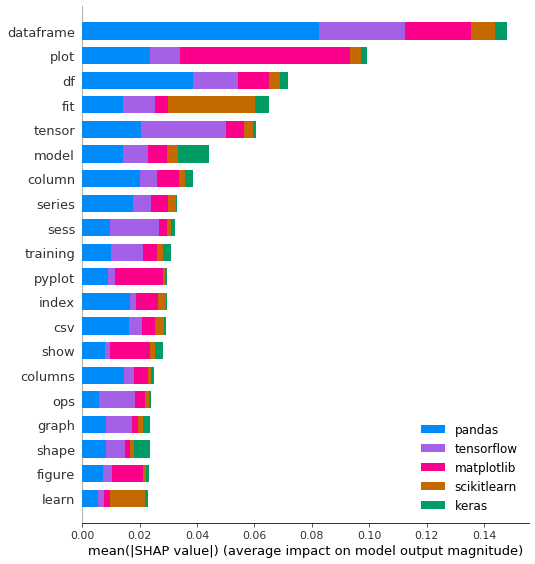

In [42]:
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=tag_encoder.classes_)

In [0]:
import colored
import re 
def colorprint(question, pos, neg):
  # Split question string on multiple chars
  q_arr = []
  q_filtered = filter(None,re.split("[, .()]+", question))
  for i in q_filtered:
    q_arr.append(i)

  color_str = []
  for idx,word in enumerate(q_arr):
    if word in pos:
      color_str.append(colored.fg("blue") + word)
    elif word in neg:
      color_str.append(colored.fg("light_red") + word)
    else:
      color_str.append(colored.fg('black') + word)

    # For wrapped printing
    if idx % 15 == 0 and idx > 0:
      color_str.append('\n')

  print(' '.join(color_str) + colored.fg('black') + " ")

In [44]:
# Print highlighted signal words for a few questions
examples_to_print = [0,7,20,22,24]

for i in range(len(examples_to_print)):
  
  # Print the actual labels
  actual = test_tags[examples_to_print[i]]
  num_labels = np.sum(actual)

  actual_labels = np.argpartition(actual, -num_labels)[-num_labels:]
  
  # Print the predicted labels
  print('Predicted labels:')
  pred_tag = model.predict([[body_test[examples_to_print[i]]]])
  for idx,tagprob in enumerate(pred_tag[0]):
    if tagprob > 0.8:
      print(tag_encoder.classes_[idx])
  print('\n')

  # Get the highest and lowest signaling words
  for idx,tag in enumerate(pred_tag[0]):
    if tag > 0.7:
      attributions = shap_vals[idx][examples_to_print[i]]
      top_signal_words = np.argpartition(attributions, -5)[-5:]
      pos_words = []
      for word_idx in top_signal_words:
        signal_wd = word_lookup[word_idx]
        pos_words.append(signal_wd)

      negative_signal_words = np.argpartition(attributions, 5)[:5]
      neg_words = []
      for word_idx in negative_signal_words:
        signal_wd = word_lookup[word_idx]
        neg_words.append(signal_wd)
      colorprint(test_qs[examples_to_print[i]],pos_words, neg_words)
  print('\n')

Predicted labels:
pandas


i want to subtract each column from the previous non-null column using the diff function i 
 have a long list of columns and i want to subtract the previous column from 
 the current column and replace the current column with the difference so if i have: 
 a b c d 1 nan 3 7 3 nan 8 10 2 nan 6 
 11 i want the output to be: a b c d 1 nan 2 4 
 3 nan 5 2 2 nan 4 5 i have been trying to use this 
 code: df2 = df1 diff axis=1 but this does not produce the desired output thanks 
 in advance 


Predicted labels:
tensorflow


trying to use if in avocado's map_fn i'm trying to apply a transformation to a column 
 vector using map_fn in avocado and it's not working for the following column vector: elems 
 = np array [[1 0] [2 0] [3 0]] when i do this: avocado_m = 
 avocado map_fn lambda x: x + 1 0 elems with avocado session as sess: res 
 = sess run avocado_m print str res i get the result that i expect namely 
 this column vector: [[2 ] [3 ] [4 ]] however when i do th